# Laboratorio Unidad III — Detección de Anomalías (C-MAPSS)



## Instrucciones rápidas
1. Instalar dependencias: `pip install -r requirements.txt`.
2. Ejecutar las celdas en orden.


In [1]:
# Configuración y cargas
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Añadir repo al path (si se usa el paquete anomaly creado)
import sys
ROOT = Path('.').resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

DATA_DIR = ROOT
FD = 'FD001'  # dataset a usar
WINDOW_SIZE = 30
# TRAINING EPOCHS (configurables para pruebas rápidas)
EPOCHS_AE = 5
EPOCHS_LSTM = 5
EPOCHS_TCN = 5

print('Working dir:', ROOT)


Working dir: C:\Users\infos\OneDrive - FUNDACIóNUNIVERSIDADINTERCONTINENTALDELAEMPRESA\4º AÑO\1ª EV 4º AÑO\EMPRESA INTELIGENTE Y GEMELOS DIGITALES\NASA


In [3]:
# Importar los módulos que creamos en la carpeta `anomaly`
from anomaly.data import load_cmapss, add_rul, compute_scaler, scale_df, build_sequence_windows
from anomaly.models import (
    z_score_scores, pca_reconstruction_scores, isolation_forest_score, oneclass_svm_score,
    dense_autoencoder_train_predict, lstm_autoencoder_train_predict, tcn_vae_train_predict
)
from anomaly.train_eval import threshold_from_train, detect_point

# Cargar datos
train_df, test_df, rul = load_cmapss(DATA_DIR, fd_id=FD)
train_df = add_rul(train_df)
print('Train rows:', train_df.shape, 'Test rows:', test_df.shape, 'RUL len:', len(rul))


Train rows: (20631, 27) Test rows: (13096, 26) RUL len: 100


In [4]:
# Seleccionar features (os1-3 y s1-s21) y normalizar por training set
feature_cols = [c for c in train_df.columns if c.startswith('os') or c.startswith('s')]
mu, sigma, feature_cols = compute_scaler(train_df, feature_cols)
train_scaled = scale_df(train_df, mu, sigma, feature_cols)
test_scaled = scale_df(test_df, mu, sigma, feature_cols)
train_scaled[['unit','time','RUL']] = train_df[['unit','time','RUL']]  # keep indexes consistent
print('Features used:', feature_cols)


Features used: ['os1', 'os2', 'os3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']


## Tarea 1 —> Implementación de métodos (cálculo de scores)
Calculamos scores por fila o por ventana según corresponda.


In [5]:
# Z-scores (row-wise)
z_train_scores, z_pf = z_score_scores(train_scaled, feature_cols)
z_thr = threshold_from_train(z_train_scores, factor=3.0)
z_test_scores, z_pf_test = z_score_scores(test_scaled, feature_cols)
print('Z-threshold:', z_thr)

# PCA reconstruction error
pca_train_err, _ = pca_reconstruction_scores(train_scaled, train_scaled, feature_cols)
pca_thr = threshold_from_train(pca_train_err, factor=3.0)
pca_test_err, pca_feat_err = pca_reconstruction_scores(train_scaled, test_scaled, feature_cols)
print('PCA-threshold:', pca_thr)

# Isolation Forest
iso_train, _ = isolation_forest_score(train_scaled, train_scaled, feature_cols)
iso_thr = threshold_from_train(iso_train, factor=3.0)
iso_test, _ = isolation_forest_score(train_scaled, test_scaled, feature_cols)
print('Isolation-threshold:', iso_thr)

# One-Class SVM
oc_train, _ = oneclass_svm_score(train_scaled, train_scaled, feature_cols)
oc_thr = threshold_from_train(oc_train, factor=3.0)
oc_test, _ = oneclass_svm_score(train_scaled, test_scaled, feature_cols)
print('OCSVM-threshold:', oc_thr)


Z-threshold: 4.829062863571225
PCA-threshold: 0.12929722511162714
PCA-threshold: 0.12929722511162714
Isolation-threshold: 0.5887022688693606
Isolation-threshold: 0.5887022688693606
OCSVM-threshold: 0.8913538034333852
OCSVM-threshold: 0.8913538034333852


In [13]:
# Dense Autoencoder (row-wise) - entrenar rápido para demo (usa fallback si TF no está disponible)
# Importamos el wrapper que usa TF si está disponible o un MLP fallback en caso contrario
from anomaly.fallback import dense_autoencoder_train_predict_wrapper as dense_autoencoder_train_predict
ae_train_err, ae_train_feat_err, ae_model = dense_autoencoder_train_predict(train_scaled, train_scaled, feature_cols, latent_dim=8, epochs=EPOCHS_AE, batch_size=256)
ae_thr = threshold_from_train(ae_train_err, factor=3.0)
ae_test_err, ae_test_feat_err, _ = dense_autoencoder_train_predict(train_scaled, test_scaled, feature_cols, latent_dim=8, epochs=1, batch_size=256)
print('AE threshold:', ae_thr)


C:\Users\infos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


AE threshold: 0.2729001430924475


C:\Users\infos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [24]:
# Construir ventanas de entrenamiento
train_windows = []
for u in train_scaled['unit'].unique():
    w = build_sequence_windows(train_scaled, u, feature_cols, window_size=WINDOW_SIZE)
    if w.size:
        train_windows.append(w)
if len(train_windows):
    train_windows = np.vstack(train_windows)
else:
    train_windows = np.empty((0, WINDOW_SIZE, len(feature_cols)))
print('Train windows shape:', train_windows.shape)

# Usar wrappers que llaman TF si está disponible o un fallback MLP si no lo está
import anomaly.fallback as fallback
# resolver funciones de wrapper de forma segura (getattr evita ImportError si las funciones no están expuestas)
# Prefer wrappers from fallback module; if TF is available in models, prefer TF implementations
lstm_autoencoder_train_predict = getattr(fallback, 'lstm_autoencoder_train_predict_wrapper', None)
tcn_vae_train_predict = getattr(fallback, 'tcn_vae_train_predict_wrapper', None)
from anomaly import models as models
# Use TF implementations only when TF_AVAILABLE is True to avoid RuntimeError
if getattr(models, 'TF_AVAILABLE', False):
    lstm_autoencoder_train_predict = getattr(models, 'lstm_autoencoder_train_predict', lstm_autoencoder_train_predict)
    tcn_vae_train_predict = getattr(models, 'tcn_vae_train_predict', tcn_vae_train_predict)
# Ensure we have callable fallbacks (if none, provide a no-op that returns empty errors)
if lstm_autoencoder_train_predict is None:
    def lstm_autoencoder_train_predict(train_windows, windows, epochs=1, batch_size=64):
        return np.array([]), np.array([]), None
if tcn_vae_train_predict is None:
    def tcn_vae_train_predict(train_windows, windows, epochs=1, batch_size=64):
        return np.array([]), np.array([]), None

# Entrenar LSTM-AE (rápido) y computar umbral
if train_windows.shape[0] > 0:
    lstm_train_err, _, lstm_model = lstm_autoencoder_train_predict(train_windows, train_windows, epochs=EPOCHS_LSTM, batch_size=64)
    lstm_thr = threshold_from_train(lstm_train_err, factor=3.0)
    print('LSTM thr:', lstm_thr)
else:
    lstm_train_err = np.array([])
    lstm_thr = np.inf

# Entrenar TCN-VAE (rápido)
if train_windows.shape[0] > 0:
    tcn_train_err, _, tcn_model = tcn_vae_train_predict(train_windows, train_windows, epochs=EPOCHS_TCN, batch_size=64)
    tcn_thr = threshold_from_train(tcn_train_err, factor=3.0)
    print('TCN thr:', tcn_thr)
else:
    tcn_train_err = np.array([])
    tcn_thr = np.inf


Train windows shape: (17731, 30, 24)
LSTM thr: nan
TCN thr: nan


C:\Users\infos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\infos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\infos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\infos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value enco

## Tarea 2 —> Detección del inicio de degradación por unidad

Calculamos el primer ciclo detectado por cada método y lo comparamos contra el fallo (RUL).


In [25]:
# Preparar estructuras de thresholds y test scores por método
thresholds = {
    'z': z_thr, 'pca': pca_thr, 'isolation': iso_thr, 'oneclass': oc_thr, 'ae': ae_thr,
    'lstm': lstm_thr, 'tcn': tcn_thr
}
# precompute test scores mapping per method (row-wise)
test_scores = {}
test_scores['z'] = z_test_scores
test_scores['pca'] = pca_test_err
test_scores['isolation'] = iso_test
test_scores['oneclass'] = oc_test
test_scores['ae'] = ae_test_err

units = sorted(test_scaled['unit'].unique())
detections = {m: {} for m in thresholds.keys()}

for u in units:
    rows = test_scaled[test_scaled['unit']==u].sort_values('time')
    idx = rows.index
    ncycles = rows.shape[0]
    # row methods
    for m in ['z','pca','isolation','oneclass','ae']:
        scores = test_scores[m][idx]
        thr = thresholds[m]
        det = detect_point(scores, thr)
        detections[m][u] = {'det_cycle': det, 'ncycles': ncycles}
    # sequence methods: build windows and score by mapping window->cycle (last cycle in window)
    win = build_sequence_windows(test_scaled, u, feature_cols, window_size=WINDOW_SIZE)
    if win.size:
        if lstm_thr < np.inf:
            lstm_err_u, _, _ = lstm_autoencoder_train_predict(train_windows, win, epochs=1, batch_size=64)
            det_w = detect_point(lstm_err_u, lstm_thr)
            detections['lstm'][u] = {'det_cycle': (det_w + WINDOW_SIZE - 1) if det_w else None, 'ncycles': ncycles}
        else:
            detections['lstm'][u] = {'det_cycle': None, 'ncycles': ncycles}
        if tcn_thr < np.inf:
            tcn_err_u, _, _ = tcn_vae_train_predict(train_windows, win, epochs=1, batch_size=64)
            det_w = detect_point(tcn_err_u, tcn_thr)
            detections['tcn'][u] = {'det_cycle': (det_w + WINDOW_SIZE - 1) if det_w else None, 'ncycles': ncycles}
        else:
            detections['tcn'][u] = {'det_cycle': None, 'ncycles': ncycles}
    else:
        detections['lstm'][u] = {'det_cycle': None, 'ncycles': ncycles}
        detections['tcn'][u] = {'det_cycle': None, 'ncycles': ncycles}

# Mostrar ejemplo para una unidad (por ejemplo unit 1)
example_unit = units[0] if units else None
print('Example unit:', example_unit)


Example unit: 1


## Tarea 3 —> Visualizaciones comparativas

Graficamos la evolución temporal de los scores para una unidad de ejemplo y marcamos umbrales y detecciones.


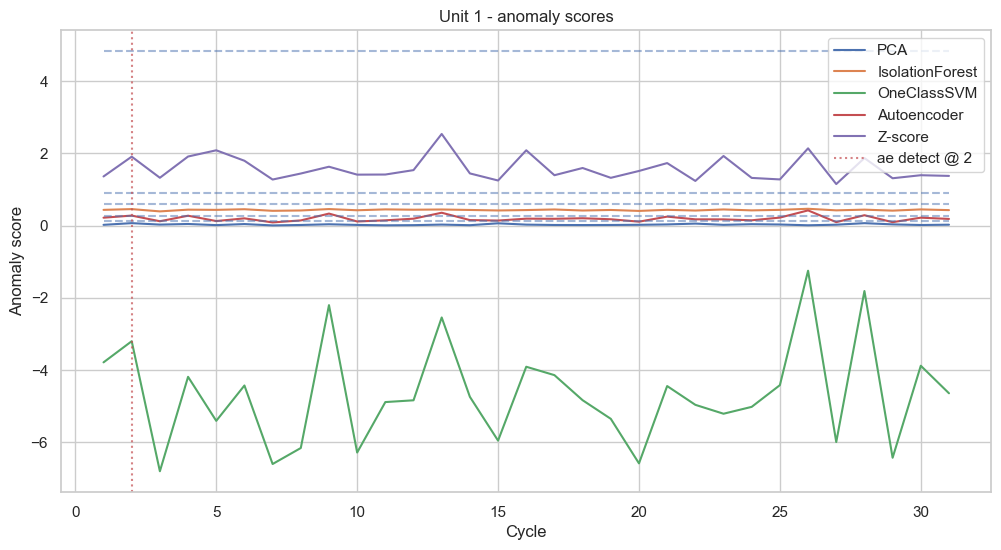

In [26]:
def plot_unit_scores(unit):
    rows = test_scaled[test_scaled['unit']==unit].sort_values('time')
    idx = rows.index
    cycles = rows['time'].values
    plt.figure(figsize=(12,6))
    plt.plot(cycles, test_scores['pca'][idx], label='PCA')
    plt.plot(cycles, test_scores['isolation'][idx], label='IsolationForest')
    plt.plot(cycles, test_scores['oneclass'][idx], label='OneClassSVM')
    plt.plot(cycles, test_scores['ae'][idx], label='Autoencoder')
    # z-score (recompute per-row for test df ordering)
    plt.plot(cycles, test_scores['z'][idx], label='Z-score')
    # thresholds (row-wise methods)
    for m in ['pca','isolation','oneclass','ae','z']:
        thr = thresholds[m]
        plt.hlines(thr, cycles.min(), cycles.max(), linestyles='--', alpha=0.5)
    # mark detection points if present
    for m, color in [('pca','C0'),('isolation','C1'),('oneclass','C2'),('ae','C3'),('z','C4')]:
        det = detections[m].get(unit,{}).get('det_cycle')
        if det is not None:
            plt.axvline(det, color=color, linestyle=':', alpha=0.7, label=f'{m} detect @ {det}')
    plt.xlabel('Cycle')
    plt.ylabel('Anomaly score')
    plt.title(f'Unit {unit} - anomaly scores')
    plt.legend()
    plt.show()

plot_unit_scores(example_unit)


## Tarea 4 —> Interpretación física y contribución por sensor

En el punto de detección de cada método, calculamos el error por sensor para identificar cuáles contribuyeron más al score.


In [27]:
def sensor_contributions_at(unit, method):
    # obtiene ciclo de detección y calcula contribución por sensor
    d = detections[method].get(unit, {})
    det = d.get('det_cycle')
    if det is None:
        return None
    # filas hasta detección
    rows = test_scaled[(test_scaled['unit']==unit) & (test_scaled['time']==det)]
    if rows.empty:
        return None
    idx = rows.index[0]
    # dependiendo del método obtenemos el error por feature (pca_feat_err, ae_test_feat_err, etc.)
    if method == 'pca':
        # pca_feat_err is (n_rows, n_features) aligned to test_scaled order
        err_vec = pca_feat_err[idx] if pca_feat_err is not None else None
    elif method == 'ae':
        err_vec = ae_test_feat_err[idx] if ae_test_feat_err is not None else None
    else:
        # for methods without per-feature error, approximate via absolute feature deviation from train mean
        row = test_scaled.loc[idx, feature_cols].values
        train_mean = train_scaled[feature_cols].mean().values
        err_vec = row - train_mean
    if err_vec is None:
        return None
    abs_err = np.abs(err_vec)
    rel = 100.0 * abs_err / (np.sum(abs_err) + 1e-9)
    ranking = sorted(list(zip(feature_cols, rel)), key=lambda x: x[1], reverse=True)[:5]
    return ranking

# Ejemplo de contribuciones para el método PCA y la unidad de ejemplo
print('Top sensors (PCA):', sensor_contributions_at(example_unit, 'pca'))
print('Top sensors (AE):', sensor_contributions_at(example_unit, 'ae'))


Top sensors (PCA): None
Top sensors (AE): [('os1', 11.923568002283888), ('s2', 11.265153578219039), ('os2', 9.220042326919426), ('s11', 8.267254066323146), ('s15', 7.937028130076474)]


## Tarea 5 —> Plantilla de Informe Ejecutivo (automaticable)

A continuación se genera un resumen básico con los principales hallazgos y una tabla comparativa de detecciones por método.


In [28]:
# Tabla comparativa de detecciones (primeras 10 unidades)

rows = []
for u in units[:10]:
    ncycles = detections['pca'][u]['ncycles']
    row = {'unit': u, 'ncycles': ncycles}
    for m in thresholds.keys():
        row[m+'_det'] = detections[m][u]['det_cycle']
    rows.append(row)
df_comp = pd.DataFrame(rows)
df_comp


,unit,ncycles,z_det,pca_det,isolation_det,oneclass_det,ae_det,lstm_det,tcn_det
0,1,31,NaN,NaN,None,NaN,2,None,None
1,2,49,NaN,NaN,None,NaN,3,None,None
2,3,126,NaN,NaN,None,NaN,2,None,None
3,4,106,NaN,NaN,None,NaN,13,None,None
4,5,98,NaN,NaN,None,NaN,3,None,None
5,6,105,62.0,NaN,None,62.0,2,None,None
6,7,160,5.0,NaN,None,NaN,3,None,None
7,8,166,55.0,76.0,None,NaN,4,None,None
8,9,55,NaN,NaN,None,NaN,1,None,None
9,10,192,3.0,NaN,None,3.0,2,None,None
